In [1]:
%load_ext autoreload
%autoreload 2

import dill

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
import seaborn as sns
from pypalettes import get_hex

from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from tqdm.autonotebook import tqdm, trange

import torch 

import sys
import os
import pickle
import time
from glob import glob

if '../src/modules/' not in sys.path:
    sys.path.append('../src/modules/')

if '../src/modules/' not in sys.path:
    sys.path.append('../src/modules/')

from plot_jupyter import contour_compare, contour_data
from data_wrangle import get_days_before, get_test_set, window_mean, get_days_after
from dmd_routines import reshape_data2dmd, train_dmd, reshape_Psi2data, eval_dmd
from sic_data_functions import get_ice_data, thin_data, iiee_calc, normalise_image, thousands, millions

batched_iiee = torch.func.vmap(iiee_calc)
batched_min = torch.func.vmap(torch.min)
batched_max = torch.func.vmap(torch.max)

formatter = FuncFormatter(thousands)

formatter_mil = FuncFormatter(millions)

C:\Users\MITESH\AppData\Local\Temp\ipykernel_7564\730540056.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
window = [1,5,10,20]
#window = [1]
numyears = [2,5,7,10]
svd_ranks = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

pkl_dir = r'../outputs/pkl/pkl_bopdmd/'
stats_dir = r'../outputs/stats/'

avg_stat = []
dmd_MSE = []
dmd_MAE = []
dmd_IIEE = []

# file_list = glob(pkl_dir + "/*highres*") # Include slash or it will search in the wrong directory!!
# print('file_list {}'.format(file_list))

#file_list.sort()

for i in window:
    for j in numyears:
        file_name = 'bopdmd_sic_window_' + str(i)+ '_numyears_' + str(j) +'_highres.pkl'
        with open(pkl_dir + file_name, 'rb') as f:
          data_pkl = pickle.load(f)

        win = pd.Series([i]).repeat(data_pkl[0].shape[0])
        win.rename('window', inplace=True)
        yrs = pd.Series([j]).repeat(data_pkl[0].shape[0])
        yrs.rename('numyears', inplace=True)
        #w = [i]
        win_yrs = (pd.concat((pd.DataFrame(win),pd.DataFrame(yrs)), axis = 1))
        win_yrs.set_index(keys = np.arange(19), inplace= True)

        avg_stat.append(pd.concat((pd.DataFrame(win_yrs),data_pkl[0]), axis = 1, ignore_index= True))
        dmd_MSE.append(pd.concat((pd.DataFrame(win_yrs),data_pkl[1]), axis = 1, ignore_index= True))
        dmd_MAE.append(pd.concat((pd.DataFrame(win_yrs),data_pkl[2]), axis = 1, ignore_index= True))
        dmd_IIEE.append(pd.concat((pd.DataFrame(win_yrs),data_pkl[3]), axis = 1, ignore_index= True))


#files = list(os.listdir(pkl_directory))

#bopdmd_sic_window_1_numyears_2_highres_20240812

# with open(pkl_directory + os.sep +  files, 'rb') as f:
#     data_pkl = pickle.load(f)

avg_stat_df = pd.concat(avg_stat, ignore_index = True)
dmd_MSE_df = pd.concat(dmd_MSE, ignore_index = True)
dmd_MAE_df = pd.concat(dmd_MAE, ignore_index = True)
dmd_IIEE_df = pd.concat(dmd_IIEE, ignore_index = True)

In [3]:
column_indices = [0,1,2,3,4,5]
new_names = ['Window','History','SVD rank','MSE', 'IIEE', 'MAE']
old_names = avg_stat_df.columns[column_indices]
avg_stat_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)
avg_stat_df["IIEE"] = avg_stat_df["IIEE"]*(25**2)

In [4]:
#avg_stat_df.to_csv(stats_dir + "avg_stat_df.csv")

#used excel to quickly pivot and load data to latex

In [4]:
column_indices = [0,1,2]
new_names = ['Window','History','SVD rank']
old_names = dmd_MSE_df.columns[column_indices]
dmd_MSE_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

old_names = dmd_MAE_df.columns[column_indices]
dmd_MAE_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

old_names = dmd_IIEE_df.columns[column_indices]
dmd_IIEE_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

In [6]:
a1 = (1,2,3)

a2 = str(a1)

print(a1, a2)

(1, 2, 3) (1, 2, 3)


In [5]:
def create_boxplot(input_df, window,history, metric):
    window = str(window)
    history = str(history)
    temp = input_df.query('Window == '+ window + ' & History == ' + history)
    temp_melt = temp[temp.columns[2:]].melt('SVD rank', var_name = 'pred_day',value_name = metric )
    sns.boxplot(data= temp_melt, x = 'SVD rank', y = metric)

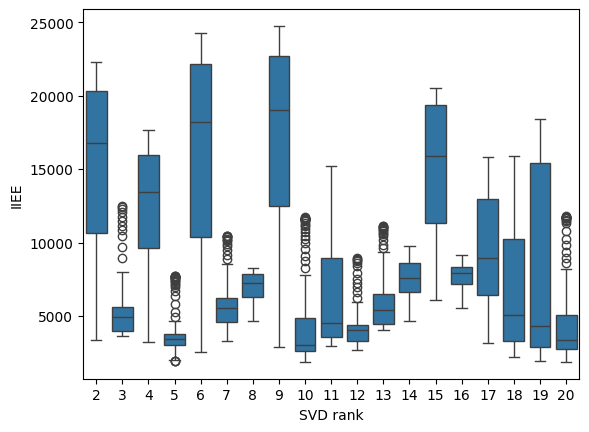

In [6]:
create_boxplot(dmd_IIEE_df, 10,10, 'IIEE')

In [7]:
avg_stat_df_1 = avg_stat_df.query('Window == 1 & History in (2,5,7,10)')

In [8]:
def query_boxplot(qry, metric, input_df, plt_title,shade = "BluetoGray_8", yxformat = None):
    
    temp_df = input_df.query(qry)
    melt_df = temp_df[temp_df.columns[1:]].melt(['SVD rank', 'History'], var_name = 'pred_day',value_name = metric )

    if metric == 'IIEE':
        melt_df["IIEE"] = melt_df["IIEE"]*(25**2)

    fig, axs = plt.subplots(1, 1, figsize=(16, 7))

    #palette = get_hex("Bmlunge")
    sns.set_theme()
    palette = get_hex(shade, keep_first_n=8)
    sns.set_style("darkgrid")
    ax_sns = sns.boxplot(data= melt_df, x = 'SVD rank', y = metric , hue = "History" , ax = axs, palette= palette)
    #ax_sns.set_title("Distribution of IIEE  - Forecasted SIC images")
    ax_sns.set_title(plt_title)

    if yxformat is not None:
        ax_sns.yaxis.set_major_formatter(yxformat)

    l = ax_sns.legend(title= 'History:', bbox_to_anchor=(0.2, -0.07), ncol = 5, loc = 'center', frameon=False)
    #sns.move_legend(ax_sns, "center", bbox_to_anchor=(0.5, -0.15), ncol = 5, frameon=False)
    l.get_title().set_position((-190, -21))

    #sns.set_style()
    plt.plot()


C:\Users\MITESH\AppData\Local\Temp\ipykernel_7564\4024357698.py:15: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax_sns = sns.boxplot(data= melt_df, x = 'SVD rank', y = metric , hue = "History" , ax = axs, palette= palette)
C:\Users\MITESH\AppData\Local\Temp\ipykernel_7564\4024357698.py:15: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax_sns = sns.boxplot(data= melt_df, x = 'SVD rank', y = metric , hue = "History" , ax = axs, palette= palette)
C:\Users\MITESH\AppData\Local\Temp\ipykernel_7564\4024357698.py:15: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax_sns = sns.boxplot(data= melt_df, x = 'SVD rank', y = metric , hue = "History" , ax = axs, palette= palette)
C:\Users\MITESH\AppData\Local\Temp\ipykernel_7564\4024357698.py:15: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax_sns = sn

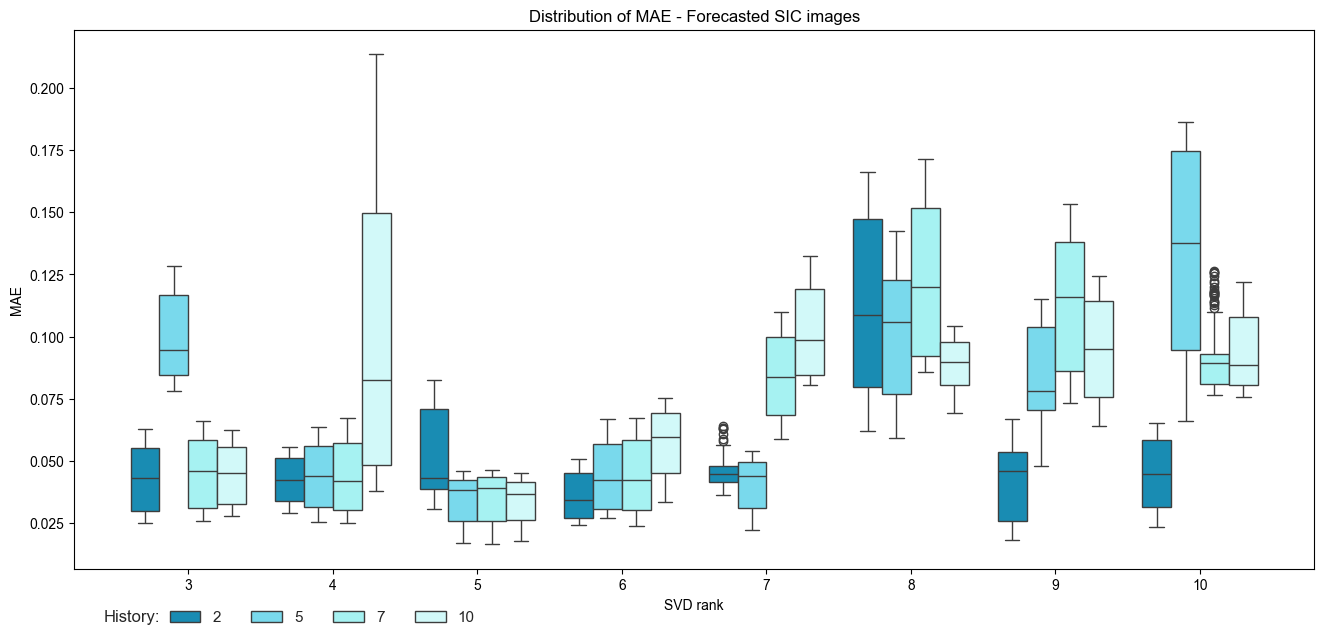

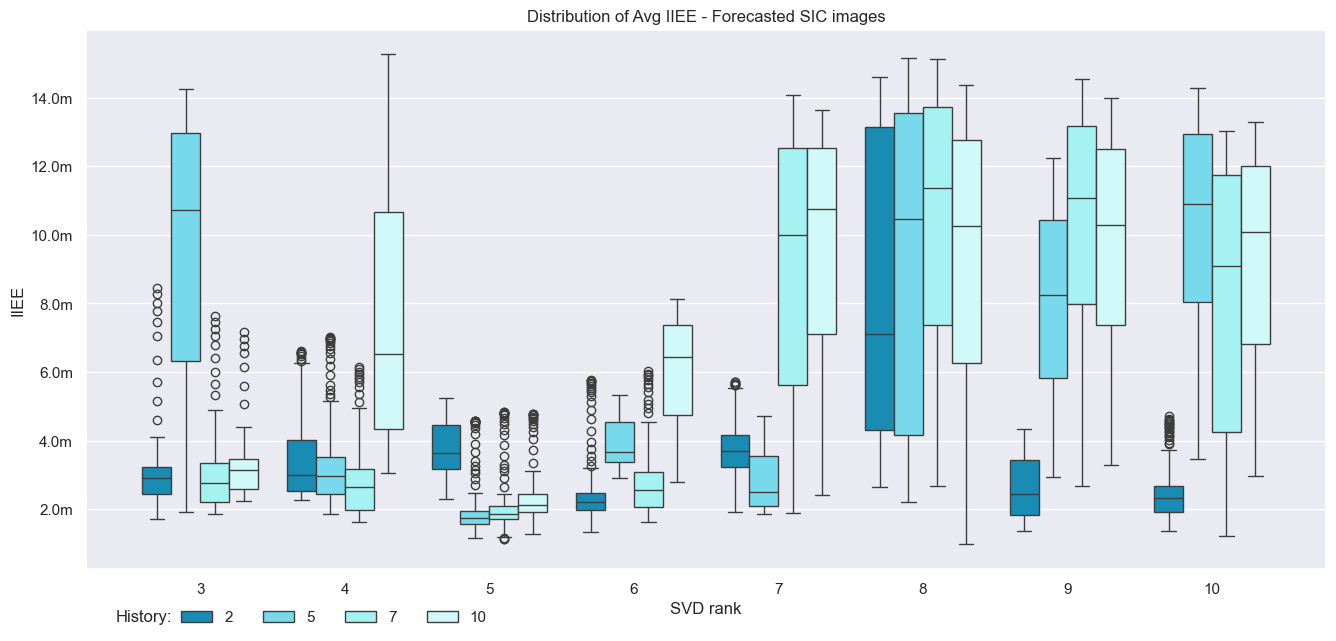

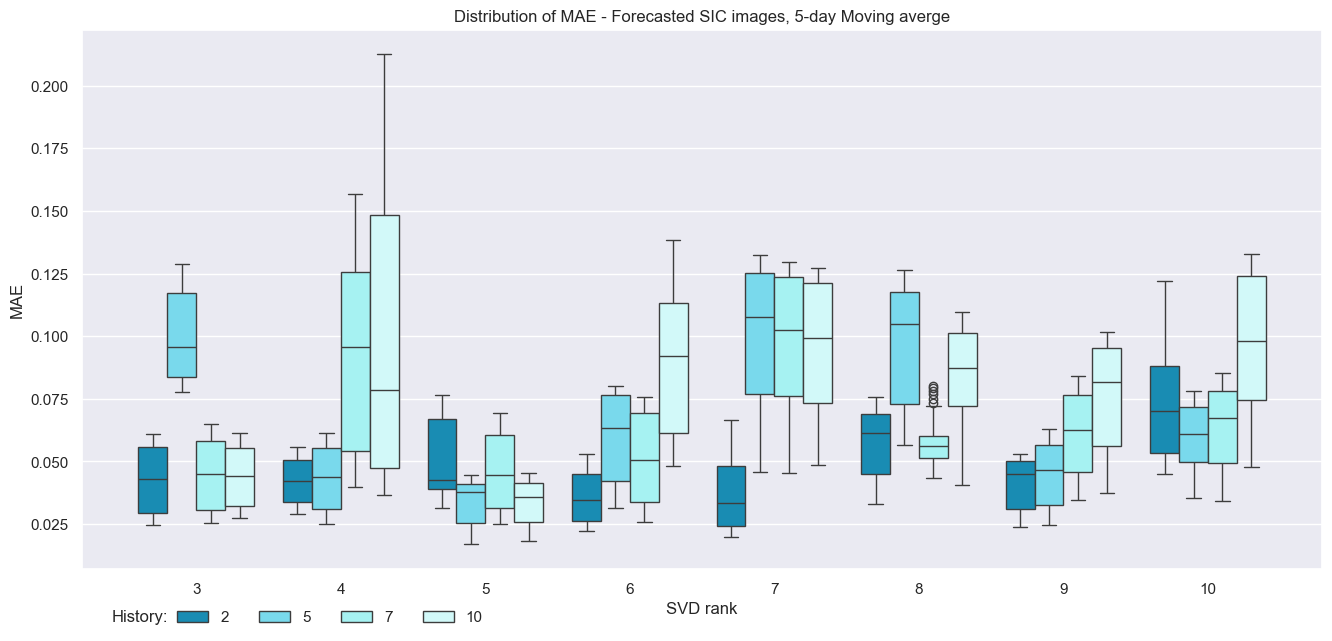

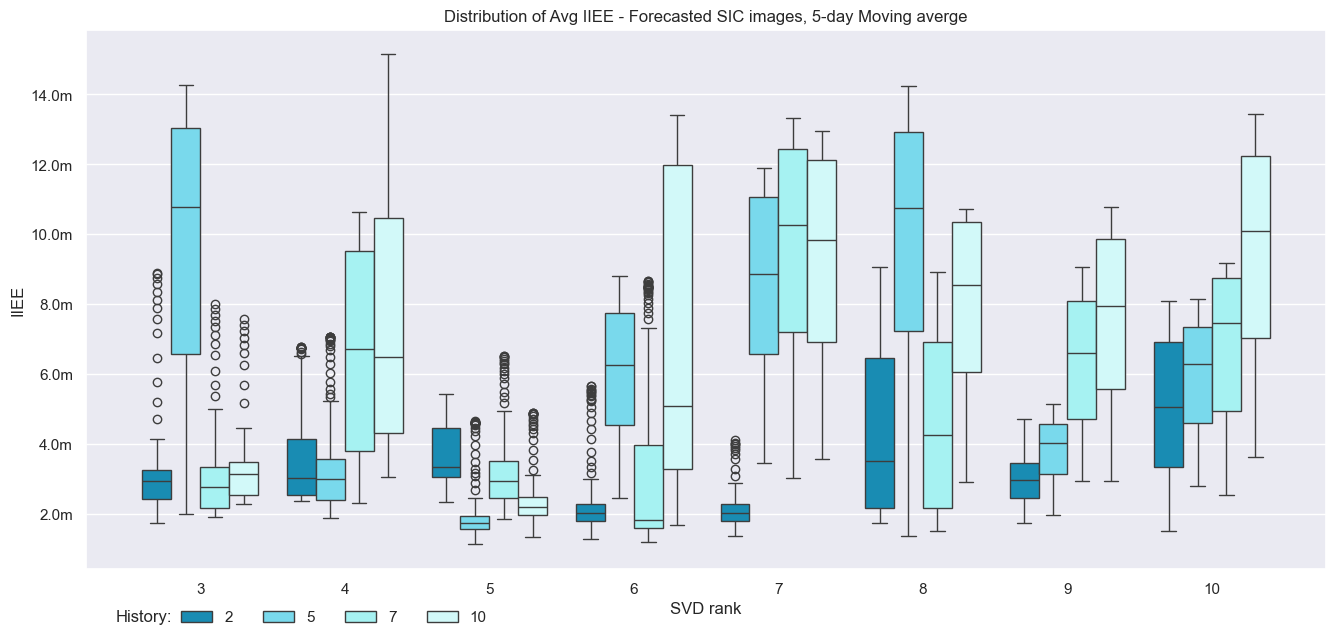

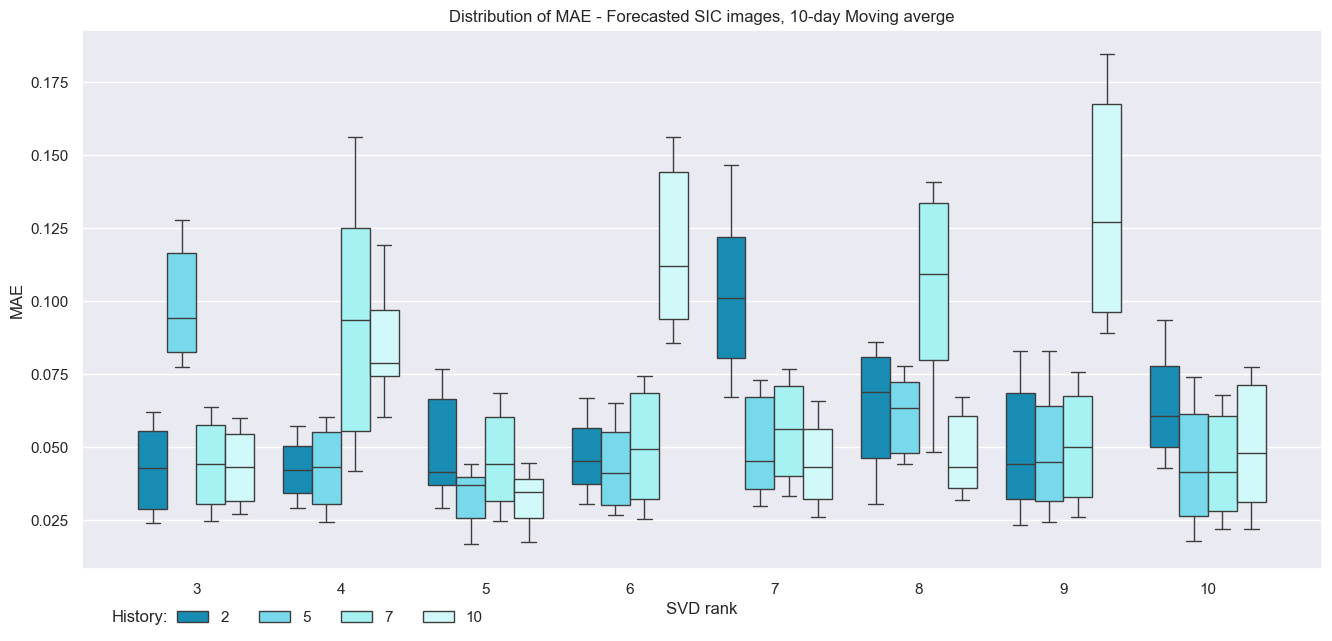

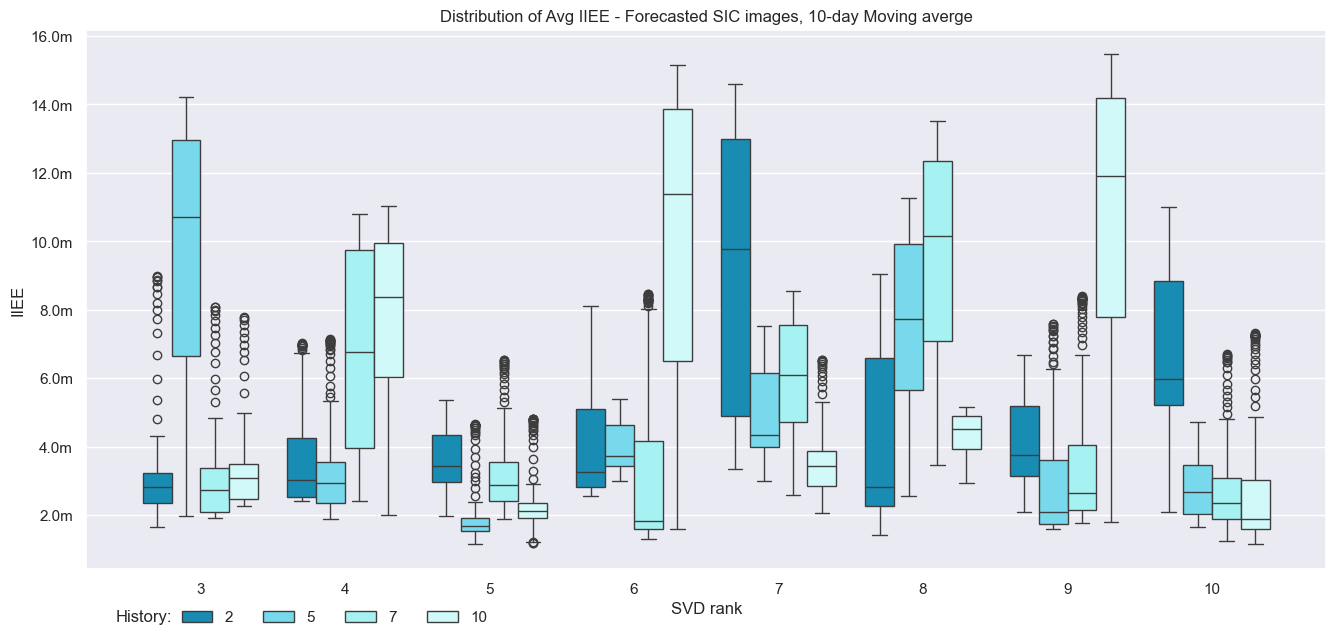

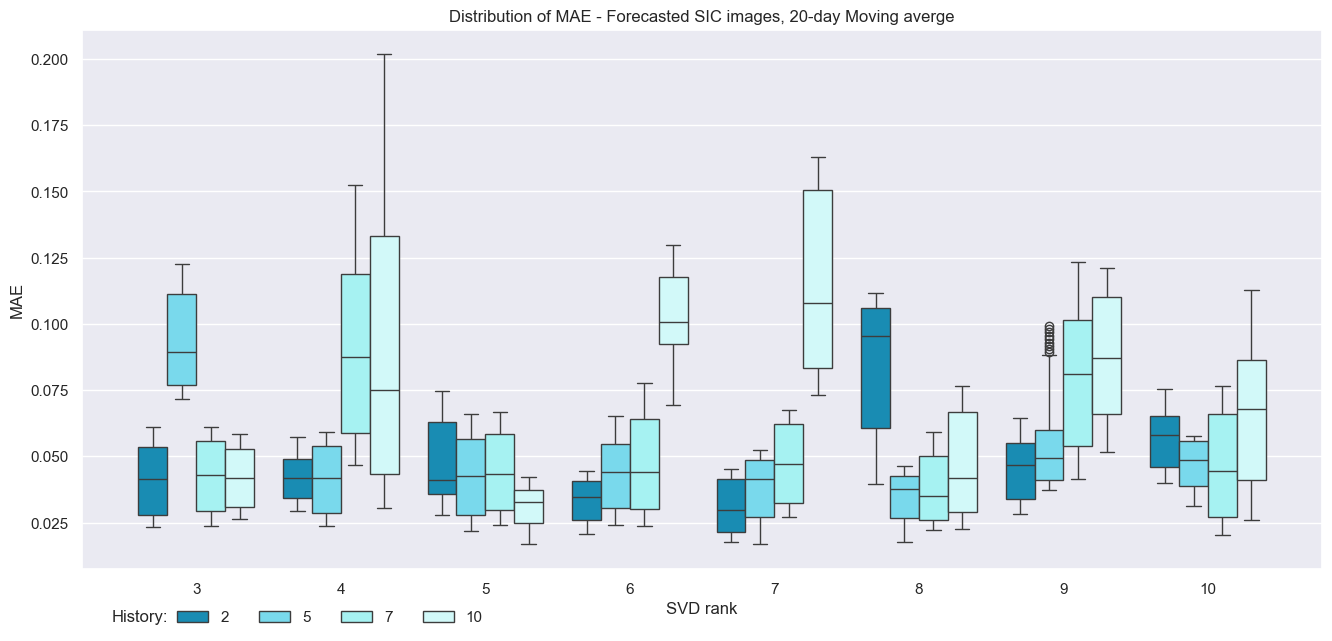

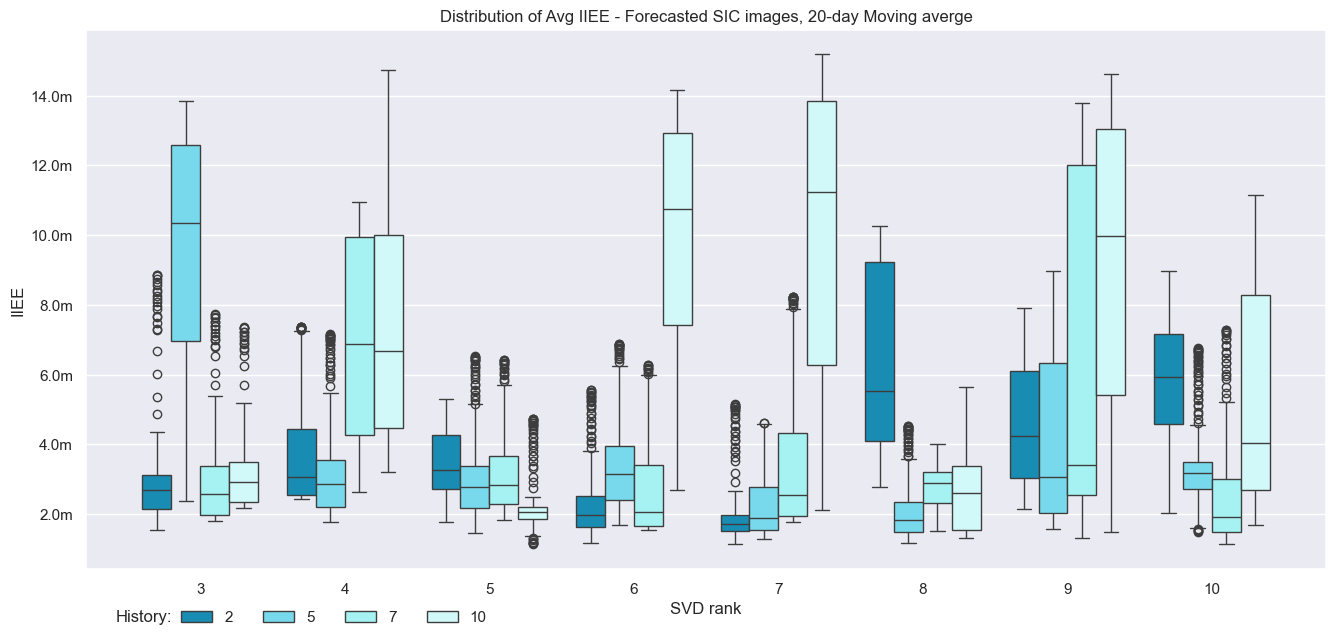

In [9]:
win = 1
svd_u = 11
svd_l = 2

input_qry = 'Window == {} & History in (2,5,7,10) & `SVD rank` < {} & `SVD rank` > {}'.format(win, svd_u, svd_l)

query_boxplot(input_qry, "MAE", dmd_MAE_df,"Distribution of MAE - Forecasted SIC images" )
query_boxplot(input_qry, "IIEE", dmd_IIEE_df,"Distribution of Avg IIEE - Forecasted SIC images", yxformat = formatter_mil)

for i in [5,10,20]:
    input_qry = 'Window == {} & History in (2,5,7,10) & `SVD rank` < {} & `SVD rank` > {}'.format(i, svd_u, svd_l)
    query_boxplot(input_qry, "MAE", dmd_MAE_df,"Distribution of MAE - Forecasted SIC images, {}-day Moving averge".format(i) )
    query_boxplot(input_qry, "IIEE", dmd_IIEE_df,"Distribution of Avg IIEE - Forecasted SIC images, {}-day Moving averge".format(i), yxformat = formatter_mil)

In [12]:
# dmd_IIEE_df_1 = dmd_IIEE_df.query('Window == 5 & History in (2,5,7,10) & `SVD rank` < 10')
# dmd_IIEE_df_1_melt = dmd_IIEE_df_1[dmd_IIEE_df_1.columns[1:]].melt(['SVD rank', 'History'], var_name = 'pred_day',value_name = 'IIEE' )

# fig, axs = plt.subplots(1, 1, figsize=(16, 7))

# #palette = get_hex("Bmlunge")
# sns.set_theme()
# palette = get_hex("BluetoGray_8", keep_first_n=8)
# #sns.set_style("darkgrid")
# ax_sns = sns.boxplot(data= dmd_IIEE_df_1_melt, x = 'SVD rank', y = 'IIEE' , hue = "History" , ax = axs, palette= palette)
# ax_sns.set_title("Distribution of IIEE  - Forecasted SIC images")
# ax_sns.yaxis.set_major_formatter(formatter)

# l = ax_sns.legend(title= 'History:', bbox_to_anchor=(0.2, -0.07), ncol = 5, loc = 'center', frameon=False)
# #sns.move_legend(ax_sns, "center", bbox_to_anchor=(0.5, -0.15), ncol = 5, frameon=False)
# l.get_title().set_position((-190, -21))

# #sns.set_style()
# plt.plot()
# #sns.boxplot(data= dmd_IIEE_df_2_melt, x = 'SVD rank', y = 'IIEE' , ax = axs)

In [24]:
def melf_frame_lineplot(input_mae,input_iiee, qry):
    temp_df = input_mae.query(qry)
    temp_df2 = input_iiee.query(qry)

    temp_df = temp_df[temp_df.columns[1:]].melt(['SVD rank', 'History'], var_name = 'pred_day',value_name = 'MAE' )
    temp_df['pred_day'] = temp_df['pred_day']-2


    temp2_df = temp_df2[temp_df2.columns[1:]].melt(['SVD rank', 'History'], var_name = 'pred_day',value_name = 'IIEE' )
    temp2_df['pred_day'] = temp2_df['pred_day']-2
    temp2_df["IIEE"]  = temp2_df["IIEE"]*(25**2)

    return temp_df, temp2_df

In [32]:
melted_dfs = []
title_list = []

best_win_his = [(1,5,5)]

for i in best_win_his:
    m,n,o = i
    input_qry = 'Window == {} & History == {} & `SVD rank` == {}'.format(m,n,o)

    out_df1, out_df2 = melf_frame_lineplot(dmd_MAE_df, dmd_IIEE_df, input_qry)
    melted_dfs.append(out_df1)
    melted_dfs.append(out_df2)
    if m == 1:
        temp_title = "{}-years of historical data with SVD rank: {}".format(n,o)
    else:
        temp_title = "Moving averge window: {} using {}-years of historical data with SVD rank: {}".format(m,n,o)
    title_list.append(temp_title)

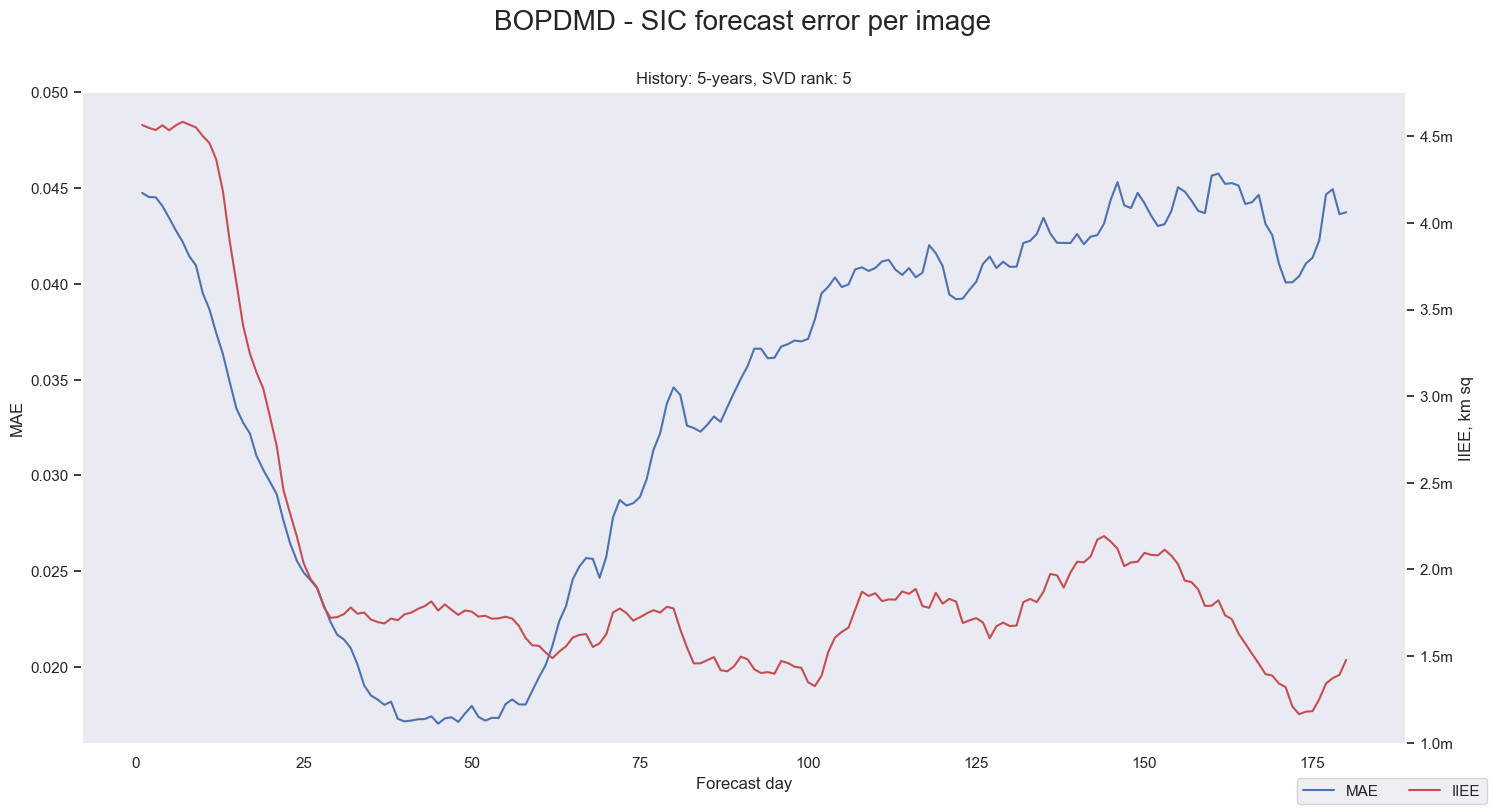

In [34]:
import seaborn as sns

fig, axs = plt.subplots(1, 1, figsize=(15, 8))

ax1 = sns.lineplot(melted_dfs[0], x='pred_day', y = 'MAE', label ='MAE', ax =axs )
ax1.grid(False)
ax1.set(xlabel='Forecast day')
ax1.set_ylim([0.016, 0.05])
ax1.title.set_text(title_list[0])

ax2 = axs.twinx()
sns.lineplot(data=melted_dfs[1], x='pred_day', y = 'IIEE',color="r", ax=ax2, label ='IIEE')
ax2.yaxis.set_major_formatter(formatter_mil)
ax2.grid(False)
ax2.set(ylabel='IIEE, km sq')
#ax2.set_ylim([1e6, 5.0e6])

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]

lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.legend(lines, labels, loc="lower right", ncol=2)

#fig.subplots_adjust(hspace=0.1)
fig.suptitle("BOPDMD - SIC forecast error per image", size = 20, y=1)

axis_list = [ax1,ax2]

for i in axis_list: i.get_legend().remove()

#ax8.get_legend().remove()
#plt.show()
plt.tight_layout(h_pad=3, w_pad = 3)

In [13]:
min_mse = avg_stat_df[avg_stat_df["MSE"] == avg_stat_df["MSE"].min()]
min_mae = avg_stat_df[avg_stat_df["MAE"] == avg_stat_df["MAE"].min()]
min_iiee = avg_stat_df[avg_stat_df["IIEE"] == avg_stat_df["IIEE"].min()]

['#f77189', '#bb9832', '#50b131', '#36ada4', '#3ba3ec', '#e866f4']


<Axes: title={'center': 'MAE'}, xlabel='SVD rank', ylabel='MAE'>

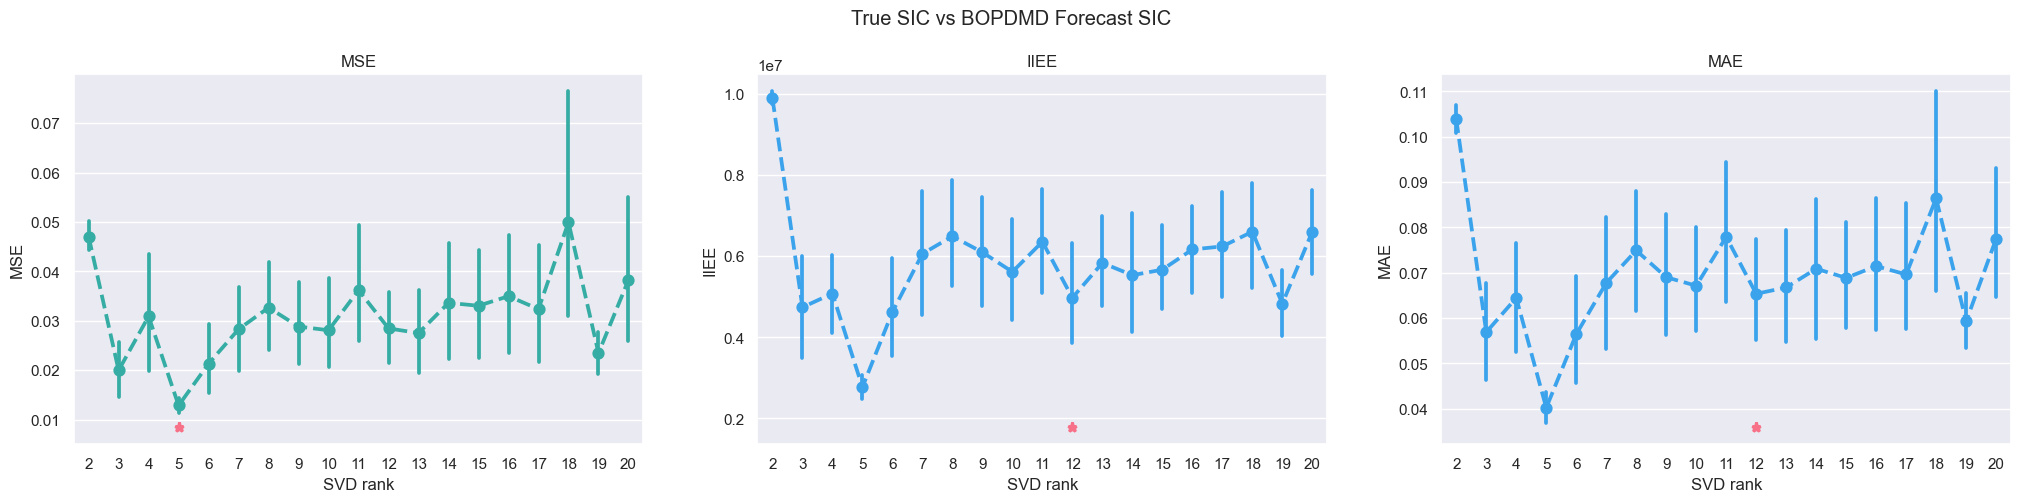

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(25, 5))

pal = sns.color_palette("husl")
print(pal.as_hex())

fig.suptitle("True SIC vs BOPDMD Forecast SIC")
fig.subplots_adjust(top=0.85)
sns.set_palette("husl",8)

sns.pointplot(data = avg_stat_df,x='SVD rank', y='MSE', ax = axs[0],linestyles='--',color= '#36ada4').set_title("MSE")
sns.pointplot(data = avg_stat_df,x='SVD rank', y='IIEE', ax = axs[1], linestyles='--', color= '#3ba3ec').set_title("IIEE")
sns.pointplot(data = avg_stat_df,x='SVD rank', y='MAE', ax = axs[2], linestyles='--', color= '#3ba3ec').set_title("MAE")
#
#axs[0].plot(min_mse["SVD_rank"], min_mse["MSE"], marker="*", color="r", markersize=10)

sns.pointplot(data = min_mse,x='SVD rank', y='MSE', ax = axs[0], markers= '*', color= '#f77189')
sns.pointplot(data = min_iiee,x='SVD rank', y='IIEE', ax = axs[1], markers= '*', color= '#f77189')
sns.pointplot(data = min_iiee,x='SVD rank', y='MAE', ax = axs[2], markers= '*', color= '#f77189')

#plt.show()